In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Explain PyTextRank: the algorithm

Let's look at the *TextRank* algorithm used to build a graph from a raw text, and then from that extract the top-ranked phrases. This work is based on 
["TextRank: Bringing Order into Text"](http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf),
Rada Mihalcea, Paul Tarau, _Empirical Methods in Natural Language Processing_ (2004).

---
First we perform some basic housekeeping for Jupyter, then load `spaCy` with a language model for English ...

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import spacy
nlp = spacy.load('de_core_news_lg')

Now, to get started, we'll create some text to use.

In [4]:
#text = "When Ada was twelve years old, this future 'Lady Fairy', as Charles Babbage affectionately called her, decided she wanted to fly. Ada Byron went about the project methodically, thoughtfully, with imagination and passion. Her first step, in February 1828, was to construct wings. She investigated different material and sizes. She considered various materials for the wings: paper, oilsilk, wires, and feathers. She examined the anatomy of birds to determine the right proportion between the wings and the body. She decided to write a book, Flyology, illustrating, with plates, some of her findings. She decided what equipment she would need; for example, a compass, to 'cut across the country by the most direct road', so that she could surmount mountains, rivers, and valleys. Her final step was to integrate steam with the 'art of flying."

text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."
#text = "Welche Aussagen treffen auf Ihr Promotionsverfahren zu. Ich habe einen Arbeitsvertrag an diesem Forschungsinstitut. Wesentliche Teile der Arbeit fanden an diesem Forschungsinstitut statt. Die Betreuende des Forschungsinstitutes wird Mitglied der Promotionsprüfungskommission sein. Die Betreuende des Forschungsinstitutes wird offiziell Gutachter meiner Dissertation sein."
doc = nlp(text)

How many sentences are in the parsed document and where are their boundaries?

In [5]:
from icecream import ic

for sent in doc.sents:
    ic(sent.start, sent.end)

ic| sent.start: 0, sent.end: 13
ic| sent.start: 13, sent.end: 30
ic| sent.start: 30, sent.end: 33
ic| sent.start: 33, sent.end: 34
ic| sent.start: 34, sent.end: 61
ic| sent.start: 61, sent.end: 91


What are the raw _noun chunks_ in the parsed document?

In [6]:
for chunk in doc.noun_chunks:
    ic(chunk.text)

ic| chunk.text: 'Compatibility of systems of linear constraints over the set of natural numbers'
ic| chunk.text: 'Criteria of compatibility of a system of linear Diophantine equations'
ic| chunk.text: 'strict inequations'
ic| chunk.text: 'Upper'
ic| chunk.text: ('bounds for components of a minimal set of solutions and algorithms of '
                 'construction of')
ic| chunk.text: 'types'
ic| chunk.text: ('These criteria and the corresponding algorithms for constructing a minimal '
                 'supporting set of solutions can be used in solving all the considered types '
                 'systems and systems of mixed types')


Also, does `spaCy` detect any _named entities_?

In [7]:
for ent in doc.ents:
    ic(ent.text, ent.label_, ent.start, ent.end)

ic| ent.text: ('Compatibility of systems of linear constraints over the set of natural '
               'numbers.')
    ent.label_: 'ORG'
    ent.start: 0
    ent.end: 13


Given those details about the parsed document, next we use [NetworkX](https://networkx.github.io/) to manage an in-memory graph...

In [8]:
import networkx as nx

def increment_edge (graph, node0, node1):
    ic(node0, node1)
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

Then construct a graph, sentence by sentence, based on the [spaCy part-of-speech tags](https://spacy.io/api/annotation#pos-en) tags:

In [9]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            ic(visited_tokens, visited_nodes)
            ic(list(range(len(visited_tokens) - 1, -1, -1)))
            
            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                ic(prev_token, (token.i - visited_tokens[prev_token]))
                
                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break

            ic(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes)

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)

Now iterate through the sentences to construct the lemma graph...

In [10]:
lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)
    #break # only test one sentence

ic| visited_tokens: [], visited_nodes: []
ic| list(range(len(visited_tokens) - 1, -1, -1)): []
ic| token.i: 0
    token.text: 'Compatibility'
    token.lemma_: 'Compatibility'
    token.pos_: 'PROPN'
    visited_tokens: []
    visited_nodes: []
ic| visited_tokens: [0], visited_nodes: [0]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [0]
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 1
ic| node0: 1, node1: 0
ic| token.i: 1
    token.text: 'of'
    token.lemma_: 'of'
    token.pos_: 'PROPN'
    visited_tokens: [0]
    visited_nodes: [0]
ic| visited_tokens: [0, 1], visited_nodes: [0, 1]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [1, 0]
ic| prev_token: 1, token.i - visited_tokens[prev_token]: 1
ic| node0: 2, node1: 1
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 2
ic| node0: 2, node1: 0
ic| token.i: 2
    token.text: 'systems'
    token.lemma_: 'systems'
    token.pos_: 'PROPN'
    visited_tokens: [0, 1]
    visited_nodes: [0, 1]
ic| visited_tokens: [0, 1, 2

ic| prev_token: 2, token.i - visited_tokens[prev_token]: 4
ic| token.i: 19
    token.text: 'of'
    token.lemma_: 'of'
    token.pos_: 'PROPN'
    visited_tokens: [13, 14, 15, 16, 17, 18]
    visited_nodes: [9, 1, 10, 1, 11, 12]
ic| visited_tokens: [13, 14, 15, 16, 17, 18, 19]
    visited_nodes: [9, 1, 10, 1, 11, 12, 1]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [6, 5, 4, 3, 2, 1, 0]
ic| prev_token: 6, token.i - visited_tokens[prev_token]: 2
ic| node0: 13, node1: 1
ic| prev_token: 5, token.i - visited_tokens[prev_token]: 3
ic| node0: 13, node1: 12
ic| prev_token: 4, token.i - visited_tokens[prev_token]: 4
ic| token.i: 21
    token.text: 'Diophantine'
    token.lemma_: 'Diophantine'
    token.pos_: 'PROPN'
    visited_tokens: [13, 14, 15, 16, 17, 18, 19]
    visited_nodes: [9, 1, 10, 1, 11, 12, 1]
ic| visited_tokens: [13, 14, 15, 16, 17, 18, 19, 21]
    visited_nodes: [9, 1, 10, 1, 11, 12, 1, 13]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [7, 6, 5, 4, 3, 2, 1, 0]
ic| prev_

    visited_nodes: [20, 21, 22, 1, 11, 23]
ic| visited_tokens: [34, 35, 36, 37, 38, 39, 41]
    visited_nodes: [20, 21, 22, 1, 11, 23, 1]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [6, 5, 4, 3, 2, 1, 0]
ic| prev_token: 6, token.i - visited_tokens[prev_token]: 1
ic| node0: 24, node1: 1
ic| prev_token: 5, token.i - visited_tokens[prev_token]: 3
ic| node0: 24, node1: 23
ic| prev_token: 4, token.i - visited_tokens[prev_token]: 4
ic| token.i: 42
    token.text: 'solutions'
    token.lemma_: 'solutions'
    token.pos_: 'PROPN'
    visited_tokens: [34, 35, 36, 37, 38, 39, 41]
    visited_nodes: [20, 21, 22, 1, 11, 23, 1]
ic| visited_tokens: [34, 35, 36, 37, 38, 39, 41, 42]
    visited_nodes: [20, 21, 22, 1, 11, 23, 1, 24]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [7, 6, 5, 4, 3, 2, 1, 0]
ic| prev_token: 7, token.i - visited_tokens[prev_token]: 1
ic| node0: 17, node1: 24
ic| prev_token: 6, token.i - visited_tokens[prev_token]: 2
ic| node0: 17, node1: 1
ic| prev_token: 5, token.i

ic| prev_token: 15, token.i - visited_tokens[prev_token]: 3
ic| node0: 1, node1: 21
ic| prev_token: 14, token.i - visited_tokens[prev_token]: 4
ic| token.i: 56
    token.text: 'of'
    token.lemma_: 'of'
    token.pos_: 'PROPN'
    visited_tokens: [34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 51, 52, 53, 54, 55]
    visited_nodes: [20, 21, 22, 1, 11, 23, 1, 24, 17, 25, 1, 26, 1, 1, 24, 21, 27, 28]
ic| visited_tokens: [], visited_nodes: []
ic| list(range(len(visited_tokens) - 1, -1, -1)): []
ic| token.i: 61
    token.text: 'These'
    token.lemma_: 'These'
    token.pos_: 'PROPN'
    visited_tokens: []
    visited_nodes: []
ic| visited_tokens: [61], visited_nodes: [29]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [0]
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 1
ic| node0: 30, node1: 29
ic| token.i: 62
    token.text: 'criteria'
    token.lemma_: 'criteria'
    token.pos_: 'PROPN'
    visited_tokens: [61]
    visited_nodes: [29]
ic| visited_tokens: [61, 62], vis

In [11]:
ic(seen_lemma)

ic| seen_lemma: {('Compatibility', 'PROPN'): {0},
                 ('Criteria', 'PROPN'): {13},
                 ('Diophantine', 'PROPN'): {21},
                 ('These', 'PROPN'): {61},
                 ('Upper', 'PROPN'): {33},
                 ('a', 'PROPN'): {17, 38},
                 ('algorithms', 'PROPN'): {66, 44},
                 ('all', 'PROPN'): {80, 54},
                 ('and', 'PROPN'): {43, 27, 85, 63},
                 ('bounds', 'PROPN'): {34},
                 ('compatibility', 'PROPN'): {15},
                 ('components', 'PROPN'): {36},
                 ('constraints', 'PROPN'): {5},
                 ('construction', 'PROPN'): {46},
                 ('criteria', 'PROPN'): {62},
                 ('equations', 'PROPN'): {22},
                 ('for', 'PROPN'): {67, 35, 53},
                 ('inequations', 'PROPN'): {25, 29},
                 ('linear', 'PROPN'): {4},
                 ('minimal', 'PROPN'): {39},
                 ('mixed', 'PROPN'): {88},
         

{('Compatibility', 'PROPN'): {0},
 ('of', 'PROPN'): {1, 3, 14, 16, 19, 37, 41, 45, 47, 51, 56, 87},
 ('systems', 'PROPN'): {2, 84, 86},
 ('linear', 'PROPN'): {4},
 ('constraints', 'PROPN'): {5},
 ('over', 'PROPN'): {6},
 ('the', 'PROPN'): {7, 64},
 ('set', 'PROPN'): {8},
 ('numbers', 'PROPN'): {11},
 ('Criteria', 'PROPN'): {13},
 ('compatibility', 'PROPN'): {15},
 ('a', 'PROPN'): {17, 38},
 ('system', 'PROPN'): {18},
 ('Diophantine', 'PROPN'): {21},
 ('equations', 'PROPN'): {22},
 ('strict', 'PROPN'): {24},
 ('inequations', 'PROPN'): {25, 29},
 ('and', 'PROPN'): {27, 43, 63, 85},
 ('nonstrict', 'PROPN'): {28},
 ('Upper', 'PROPN'): {33},
 ('bounds', 'PROPN'): {34},
 ('for', 'PROPN'): {35, 53, 67},
 ('components', 'PROPN'): {36},
 ('minimal', 'PROPN'): {39},
 ('solutions', 'PROPN'): {42, 52},
 ('algorithms', 'PROPN'): {44, 66},
 ('construction', 'PROPN'): {46},
 ('all', 'PROPN'): {54, 80},
 ('types', 'PROPN'): {55, 83, 89},
 ('These', 'PROPN'): {61},
 ('criteria', 'PROPN'): {62},
 ('mixe

Let's visualize the lemma graph, and for that first we need to collect a dictionary of the labels.

In [12]:
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

labels

{0: 'compatibility',
 1: 'of',
 2: 'systems',
 3: 'linear',
 4: 'constraints',
 5: 'over',
 6: 'the',
 7: 'set',
 8: 'numbers',
 9: 'criteria',
 10: 'compatibility',
 11: 'a',
 12: 'system',
 13: 'diophantine',
 14: 'equations',
 15: 'strict',
 16: 'inequations',
 17: 'and',
 18: 'nonstrict',
 19: 'upper',
 20: 'bounds',
 21: 'for',
 22: 'components',
 23: 'minimal',
 24: 'solutions',
 25: 'algorithms',
 26: 'construction',
 27: 'all',
 28: 'types',
 29: 'these',
 30: 'criteria',
 31: 'mixed'}

In [13]:
text

'Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types.'

Then use `matplotlib` to visualize the lemma graph:

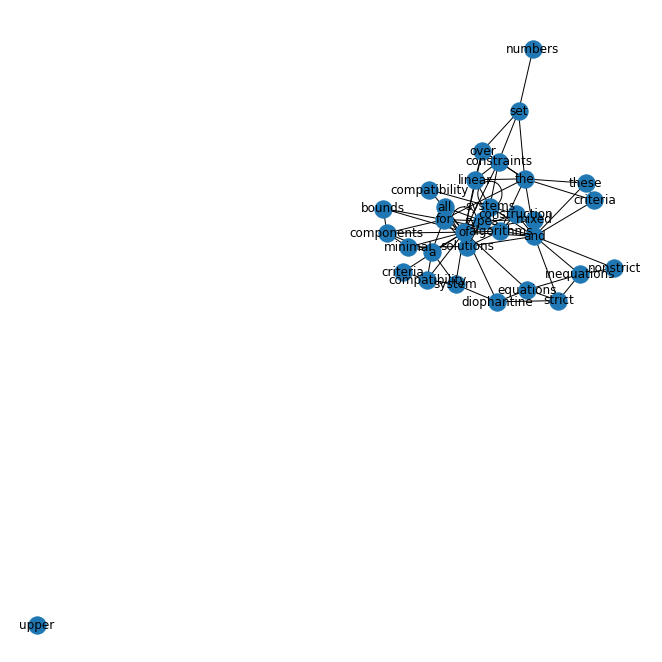

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 9))
pos = nx.spring_layout(lemma_graph)

nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold")
nx.draw_networkx_labels(lemma_graph, pos, labels);

Now to run the algorithm, we use `PageRank` – a form of
[*eigenvector centrality*](https://derwen.ai/docs/ptr/glossary/#eigenvector-centrality)
– to calculate ranks for each of the nodes in the lemma graph.

In [15]:
ranks = nx.pagerank(lemma_graph)
ranks

{0: 0.01420347687068355,
 1: 0.18255751293687555,
 2: 0.052397227736651786,
 3: 0.026529993092334725,
 4: 0.028635909715472963,
 5: 0.02522339979052568,
 6: 0.042152661622592055,
 7: 0.025917323182081745,
 8: 0.010323190990418157,
 9: 0.014819824781581928,
 10: 0.022339590321226673,
 11: 0.03868803842070992,
 12: 0.022531054292659114,
 13: 0.020813554117052425,
 14: 0.021192485911830046,
 15: 0.021463409454416528,
 16: 0.03027937186787335,
 17: 0.0726750265167058,
 18: 0.016826765743288716,
 19: 0.004815409309791333,
 20: 0.01501522144282283,
 21: 0.04259401763088043,
 22: 0.02238402371483039,
 23: 0.021362008127951915,
 24: 0.03437337031898638,
 25: 0.03528807602074187,
 26: 0.017786917503552675,
 27: 0.023907057573078323,
 28: 0.04107135740196416,
 29: 0.017063544535533257,
 30: 0.017063544535533257,
 31: 0.017705634519352437}

In [16]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    ic(node_id, rank, labels[node_id])

ic| node_id: 1, rank: 0.18255751293687555, labels[node_id]: 'of'
ic| node_id: 17, rank: 0.0726750265167058, labels[node_id]: 'and'
ic| node_id: 2, rank: 0.052397227736651786, labels[node_id]: 'systems'
ic| node_id: 21, rank: 0.04259401763088043, labels[node_id]: 'for'
ic| node_id: 6, rank: 0.042152661622592055, labels[node_id]: 'the'
ic| node_id: 28, rank: 0.04107135740196416, labels[node_id]: 'types'
ic| node_id: 11, rank: 0.03868803842070992, labels[node_id]: 'a'
ic| node_id: 25
    rank: 0.03528807602074187
    labels[node_id]: 'algorithms'
ic| node_id: 24
    rank: 0.03437337031898638
    labels[node_id]: 'solutions'
ic| node_id: 16
    rank: 0.03027937186787335
    labels[node_id]: 'inequations'
ic| node_id: 4
    rank: 0.028635909715472963
    labels[node_id]: 'constraints'
ic| node_id: 3, rank: 0.026529993092334725, labels[node_id]: 'linear'
ic| node_id: 7, rank: 0.025917323182081745, labels[node_id]: 'set'
ic| node_id: 5, rank: 0.02522339979052568, labels[node_id]: 'over'
ic| n

Define a function to collect the top-ranked phrases from the lemma graph.

In [17]:
import math

def collect_phrases (chunk, phrases, counts):
    chunk_len = chunk.end - chunk.start
    sq_sum_rank = 0.0
    non_lemma = 0
    compound_key = set([])

    for i in range(chunk.start, chunk.end):
        token = doc[i]
        key = (token.lemma_, token.pos_)
        
        if key in seen_lemma:
            node_id = list(seen_lemma.keys()).index(key)
            rank = ranks[node_id]
            sq_sum_rank += rank
            compound_key.add(key)
        
            ic(token.lemma_, token.pos_, node_id, rank)
        else:
            non_lemma += 1
    
    # although the noun chunking is greedy, we discount the ranks using a
    # point estimate based on the number of non-lemma tokens within a phrase
    non_lemma_discount = chunk_len / (chunk_len + (2.0 * non_lemma) + 1.0)

    # use root mean square (RMS) to normalize the contributions of all the tokens
    phrase_rank = math.sqrt(sq_sum_rank / (chunk_len + non_lemma))
    phrase_rank *= non_lemma_discount

    # remove spurious punctuation
    phrase = chunk.text.lower().replace("'", "")

    # create a unique key for the the phrase based on its lemma components
    compound_key = tuple(sorted(list(compound_key)))
    
    if not compound_key in phrases:
        phrases[compound_key] = set([ (phrase, phrase_rank) ])
        counts[compound_key] = 1
    else:
        phrases[compound_key].add( (phrase, phrase_rank) )
        counts[compound_key] += 1

    ic(phrase_rank, chunk.text, chunk.start, chunk.end, chunk_len, counts[compound_key])

Collect the top-ranked phrases based on both the noun chunks and the named entities...

In [18]:
phrases = {}
counts = {}

for chunk in doc.noun_chunks:
    collect_phrases(chunk, phrases, counts)

ic| token.lemma_: 'Compatibility'
    token.pos_: 'PROPN'
    node_id: 0
    rank: 0.01420347687068355
ic| token.lemma_: 'of'
    token.pos_: 'PROPN'
    node_id: 1
    rank: 0.18255751293687555
ic| token.lemma_: 'systems'
    token.pos_: 'PROPN'
    node_id: 2
    rank: 0.052397227736651786
ic| token.lemma_: 'of'
    token.pos_: 'PROPN'
    node_id: 1
    rank: 0.18255751293687555
ic| token.lemma_: 'linear'
    token.pos_: 'PROPN'
    node_id: 3
    rank: 0.026529993092334725
ic| token.lemma_: 'constraints'
    token.pos_: 'PROPN'
    node_id: 4
    rank: 0.028635909715472963
ic| token.lemma_: 'over'
    token.pos_: 'PROPN'
    node_id: 5
    rank: 0.02522339979052568
ic| token.lemma_: 'the'
    token.pos_: 'PROPN'
    node_id: 6
    rank: 0.042152661622592055
ic| token.lemma_: 'set'
    token.pos_: 'PROPN'
    node_id: 7
    rank: 0.025917323182081745
ic| token.lemma_: 'numbers'
    token.pos_: 'PROPN'
    node_id: 8
    rank: 0.010323190990418157
ic| phrase_rank: 0.14496981982431256

In [19]:
for ent in doc.ents:
    collect_phrases(ent, phrases, counts)

ic| token.lemma_: 'Compatibility'
    token.pos_: 'PROPN'
    node_id: 0
    rank: 0.01420347687068355
ic| token.lemma_: 'of'
    token.pos_: 'PROPN'
    node_id: 1
    rank: 0.18255751293687555
ic| token.lemma_: 'systems'
    token.pos_: 'PROPN'
    node_id: 2
    rank: 0.052397227736651786
ic| token.lemma_: 'of'
    token.pos_: 'PROPN'
    node_id: 1
    rank: 0.18255751293687555
ic| token.lemma_: 'linear'
    token.pos_: 'PROPN'
    node_id: 3
    rank: 0.026529993092334725
ic| token.lemma_: 'constraints'
    token.pos_: 'PROPN'
    node_id: 4
    rank: 0.028635909715472963
ic| token.lemma_: 'over'
    token.pos_: 'PROPN'
    node_id: 5
    rank: 0.02522339979052568
ic| token.lemma_: 'the'
    token.pos_: 'PROPN'
    node_id: 6
    rank: 0.042152661622592055
ic| token.lemma_: 'set'
    token.pos_: 'PROPN'
    node_id: 7
    rank: 0.025917323182081745
ic| token.lemma_: 'numbers'
    token.pos_: 'PROPN'
    node_id: 8
    rank: 0.010323190990418157
ic| phrase_rank: 0.12487130706488411

Since noun chunks can be expressed in different ways (e.g., they may have articles or prepositions), we need to find a minimum span for each phrase based on combinations of lemmas...

In [20]:
import operator

min_phrases = {}

for compound_key, rank_tuples in phrases.items():
    l = list(rank_tuples)
    l.sort(key=operator.itemgetter(1), reverse=True)
    
    phrase, rank = l[0]
    count = counts[compound_key]
    
    min_phrases[phrase] = (rank, count)

Then let's examine the results of TextRank...

In [21]:
for phrase, (rank, count) in sorted(min_phrases.items(), key=lambda x: x[1][0], reverse=True):
    ic(phrase, count, rank)

ic| phrase: ('bounds for components of a minimal set of solutions and algorithms of '
             'construction of')
    count: 1
    rank: 0.21584188501572496
ic| phrase: 'criteria of compatibility of a system of linear diophantine equations'
    count: 1
    rank: 0.19238559074803666
ic| phrase: 'compatibility of systems of linear constraints over the set of natural numbers'
    count: 2
    rank: 0.14496981982431256
ic| phrase: 'strict inequations', count: 1, rank: 0.10723057329604159
ic| phrase: 'types', count: 1, rank: 0.10133034762839334
ic| phrase: ('these criteria and the corresponding algorithms for constructing a minimal '
             'supporting set of solutions can be used in solving all the considered types '
             'systems and systems of mixed types')
    count: 1
    rank: 0.06142411391098154
ic| phrase: 'upper', count: 1, rank: 0.034696575154441876


Just for kicks, compare with raw results of the non-chunked lemma nodes...

In [22]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    ic(labels[node_id], rank)

ic| labels[node_id]: 'of', rank: 0.18255751293687555
ic| labels[node_id]: 'and', rank: 0.0726750265167058
ic| labels[node_id]: 'systems', rank: 0.052397227736651786
ic| labels[node_id]: 'for', rank: 0.04259401763088043
ic| labels[node_id]: 'the', rank: 0.042152661622592055
ic| labels[node_id]: 'types', rank: 0.04107135740196416
ic| labels[node_id]: 'a', rank: 0.03868803842070992
ic| labels[node_id]: 'algorithms', rank: 0.03528807602074187
ic| labels[node_id]: 'solutions', rank: 0.03437337031898638
ic| labels[node_id]: 'inequations', rank: 0.03027937186787335
ic| labels[node_id]: 'constraints', rank: 0.028635909715472963
ic| labels[node_id]: 'linear', rank: 0.026529993092334725
ic| labels[node_id]: 'set', rank: 0.025917323182081745
ic| labels[node_id]: 'over', rank: 0.02522339979052568
ic| labels[node_id]: 'all', rank: 0.023907057573078323
ic| labels[node_id]: 'system', rank: 0.022531054292659114
ic| labels[node_id]: 'components', rank: 0.02238402371483039
ic| labels[node_id]: 'compatib